# Is there any relationship between forest area and suicide incidence?

Required tools and libraries in this analysis:

In [11]:
import pandas as pd
import basedosdados as bd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

## Available data
### To approach this question we'll consider the following datasets:
#### 1. [Sistema de Informações sobre Mortalidade (SIM)](https://basedosdados.org/dataset/br-ms-sim?bdm_table=microdados)
Brazilian Health Ministry's report on mortality from 1996 to 2020.

We'll consider all deaths with basic cause (causa_basica, CID-10) codes: X60-X84 and Y87.0 [1] 


#### 2. [Censo Agropecuário](https://basedosdados.org/dataset/br-ibge-censo-agropecuario?bdm_table=municipio)
Brazilian Institute of Geography and Statistics' report on agriculture census from 1985 to 2017.
 
#### 3. [População brasileira](https://basedosdados.org/dataset/br_ibge_populacao?bdm_table=municipio)
Brazilian Institute of Geography and Statistics' report on estimated population from 1991 to 2021.

### 4 [Produto Interno Bruto do Brasil](https://basedosdados.org/dataset/br-ibge-pib?bdm_table=municipio)
Brazilian Institute of Geography and Statistics' report on Gross Domestic Product at current prices from 2002 to 2019.


### References:
- [1] [Mortalidade por suicídio e notificações de lesões autoprovocadas no Brasil](https://www.gov.br/saude/pt-br/centrais-de-conteudo/publicacoes/boletins/epidemiologicos/edicoes/2021/boletim_epidemiologico_svs_33_final.pdf)


## Study case: municipios, 2007 
Lets focus on the year of 2017, as it is covered by all datasets and the most recent available Censo Agropecuário.

### Data gathering

In [82]:
class Get_data:    
    def _unpack(self, l):
        return ", ".join(map(str, l))

    def _get_data(self, filename, query):
        try:
            return pd.read_csv(f'../data/{filename}.csv')
        except FileNotFoundError:
            df = bd.read_sql(query=query,
                             billing_project_id='explorando-basedosdados')
            df.to_csv(
                f'../data/{filename}.csv', index=False)
            df['id_municipio'] = df['id_municipio'].astype('int64')
        return df

    def sim_suic_municipio(self,year):
        filename = f'sim_suic_municipio_{year}'
        columns = ('id_municipio', 'SUM(numero_obitos) as numero_obitos')
        query = f"""
                SELECT 
                    {self._unpack(columns)}
                FROM 
                    basedosdados.br_ms_sim.municipio_causa
                WHERE 
                    ano = {year}
                    AND (
                        CONTAINS_SUBSTR(causa_basica, 'X6')
                        OR CONTAINS_SUBSTR(causa_basica, 'X7')
                        OR CONTAINS_SUBSTR(causa_basica, 'X8')
                        OR causa_basica = 'Y870'
                        )
                    GROUP BY id_municipio
                """
        return self._get_data(filename, query)

    def agro_forest_municipio(self,year):
        filename = f'agro_forest_municipio_{year}'
        columns = ('id_municipio',
                   'area_total',
                   'area_mata_natural',
                   'area_mata_plantada',
                   'area_sistema_agroflorestal',
                   'area_mata')
        query = f"""
                SELECT 
                    {self._unpack(columns)}
                FROM 
                    basedosdados.br_ibge_censo_agropecuario.municipio
                WHERE
                    ano = {year}
                    """
        return self._get_data(filename, query)

    def sim_suic_pop_municipio(self,year):
        query = f"""
                WITH obitos AS 
                    (
                        SELECT 
                            id_municipio, 
                            COUNT(numero_obitos) AS numero_obitos, 
                            SUM 
                                (CASE
                                    WHEN 
                                        (
                                        CONTAINS_SUBSTR(causa_basica, 'X6')
                                        OR CONTAINS_SUBSTR(causa_basica, 'X7')
                                        OR CONTAINS_SUBSTR(causa_basica, 'X8')
                                        OR causa_basica = 'Y870'
                                        )
                                    THEN 
                                        1
                                    ELSE
                                        0
                                END) AS numero_suicidios
                        FROM 
                            basedosdados.br_ms_sim.municipio_causa
                        WHERE 
                            ano = {year} 
                        GROUP BY 
                            id_municipio
                    ), 
                    populacao AS 
                        (
                            SELECT 
                                id_municipio, populacao 
                            FROM 
                                `basedosdados.br_ibge_populacao.municipio` 
                            WHERE 
                                ano = {year} 

                        )
                SELECT 
                obitos.id_municipio, obitos.numero_obitos, obitos.numero_suicidios, populacao.populacao 
                FROM 
                obitos JOIN populacao ON obitos.id_municipio = populacao.id_municipio
                """
        return self._get_data(f'sim_sui_pop_municipio_{year}',query)
        

    def pib_pc_municipio(self,year):
        query = f"""
                    SELECT 
                        pib.id_municipio,
                        (pib.PIB / pop.populacao) as pib_pc
                    FROM 
                        basedosdados.br_ibge_pib.municipio as pib
                    INNER JOIN 
                        basedosdados.br_ibge_populacao.municipio as pop
                    ON 
                        pib.id_municipio = pop.id_municipio 
                        AND 
                            pib.ano = pop.ano
                    WHERE 
                        pib.ano = {year}
                """
                
        return self._get_data(f'pib_pc_{year}',query)
    def get_dfs(self, year):
        dfs = [self.agro_forest_municipio(year),
                self.sim_suic_pop_municipio(year),
                self.pib_pc_municipio(year)]
        return dfs
get_data = Get_data()
year = 2017
agro_forest_2017, sim_sui_pop_2017, pib_pc_2017 = get_data.get_dfs(year)

In [78]:
sim_sui_pop_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_municipio      5570 non-null   object
 1   numero_obitos     5570 non-null   Int64 
 2   numero_suicidios  5570 non-null   Int64 
 3   populacao         5570 non-null   Int64 
dtypes: Int64(3), object(1)
memory usage: 190.5+ KB


In [75]:
agro_forest_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5563 entries, 0 to 5562
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_municipio                5563 non-null   int64  
 1   area_total                  5563 non-null   float64
 2   area_mata_natural           5563 non-null   float64
 3   area_mata_plantada          5563 non-null   float64
 4   area_sistema_agroflorestal  5563 non-null   float64
 5   area_mata                   5563 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 260.9 KB


In [77]:
pib_pc_2017.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_municipio  5570 non-null   int64  
 1   pib_pc        5570 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 87.2 KB


## Results

In [72]:
import functools as ft
import numpy as np

def normalize(x):
    mean_x = x.mean()
    std_x = x.std()
    return ((x - mean_x) / std_x)


def merge_dfs(dfs):
    df = ft.reduce(lambda left, right: pd.merge(left, right, on='id_municipio'), dfs)

    df['taxa_sui_10k'] = df['numero_suicidios'] / df['populacao'] * 10_000
    df['taxa_sui_obitos'] = df['numero_suicidios'] / df['numero_obitos']
    df['taxa_mata'] = df['area_mata'] / df['area_total']
    df['pib_pc_norm'] = normalize(df['pib_pc'])
    df['pib_pc_log2'] = np.log2(df['pib_pc'])
    return df

# Scatter plotting
def plot(df, x_df, y_df, c_df=None, 
        xlabel=None,
        ylabel=None,
        filename=None):
            fig = plt.figure(figsize=(20, 10))
            ax = plt.subplot()
            base_colors = [
                "#E66E52",
                "#F3A061",
                "#E8C36A",
                "#87D397",
                "#22926E",
                "#184C5F",
            ]
            base_cmap = ListedColormap(base_colors)

            df.plot.scatter(
                x=x_df,
                y=y_df,
                c=c_df,
                ax=ax,
                cmap=base_cmap,
                alpha=0.85,
            )
            
            ax.set_xlabel(xlabel, fontsize=20)
            ax.set_ylabel(ylabel, fontsize=20)
            if filename != None:
                fig.savefig(f'../data/output/{filename}',dpi=300)
            return ax
    

In [83]:
dfs_2017 = [sim_sui_pop_2017, agro_forest_2017, pib_pc_2017] 
df_2017 = merge_dfs(dfs_2017)
df_2017.describe()

,id_municipio,numero_obitos,numero_suicidios,populacao,area_total,area_mata_natural,area_mata_plantada,area_sistema_agroflorestal,area_mata,pib_pc,taxa_sui_10k,taxa_sui_obitos,taxa_mata,pib_pc_norm,pib_pc_log2
count,5.563000e+03,5563.000000,5563.000000,5.563000e+03,5.563000e+03,5.563000e+03,5563.000000,5563.000000,5.563000e+03,5563.000000,5563.000000,5563.000000,5557.000000,5.563000e+03,5563.000000
mean,3.253405e+06,76.238720,1.212116,3.709917e+04,6.314733e+04,1.656131e+04,1392.484091,2406.092396,1.795379e+04,22011.842346,0.656804,0.015322,0.238663,-1.759353e-15,14.054640
std,9.854879e+05,101.009917,2.261321,2.184221e+05,1.388213e+05,4.775899e+04,6657.367887,7872.561965,4.924679e+04,20895.455774,1.074046,0.019932,0.173618,1.000000e+00,0.980540
min,1.100015e+06,3.000000,0.000000,8.120000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,3289.500094,0.000000,0.000000,0.000000,-8.960007e-01,11.683653
25%,2.512056e+06,27.000000,0.000000,5.499500e+03,1.182650e+04,1.485000e+03,0.000000,0.000000,1.693500e+03,9487.474062,0.000000,0.000000,0.113854,-5.993824e-01,13.211808
50%,3.146107e+06,48.000000,1.000000,1.160800e+04,2.448100e+04,4.036000e+03,26.000000,89.000000,4.661000e+03,16588.393665,0.264880,0.010526,0.197304,-2.595516e-01,14.017887
75%,4.119276e+06,86.000000,2.000000,2.521250e+04,5.750800e+04,1.216100e+04,544.500000,1207.500000,1.395950e+04,27140.013387,0.882653,0.023810,0.316670,2.454204e-01,14.728134
max,5.300108e+06,1995.000000,52.000000,1.210692e+07,4.810916e+06,1.125556e+06,227250.000000,206666.000000,1.125574e+06,346739.343545,15.313936,0.285714,0.975643,1.554058e+01,18.403492


<AxesSubplot:xlabel='Proporção de mata por área', ylabel='Incidência de suicidio'>

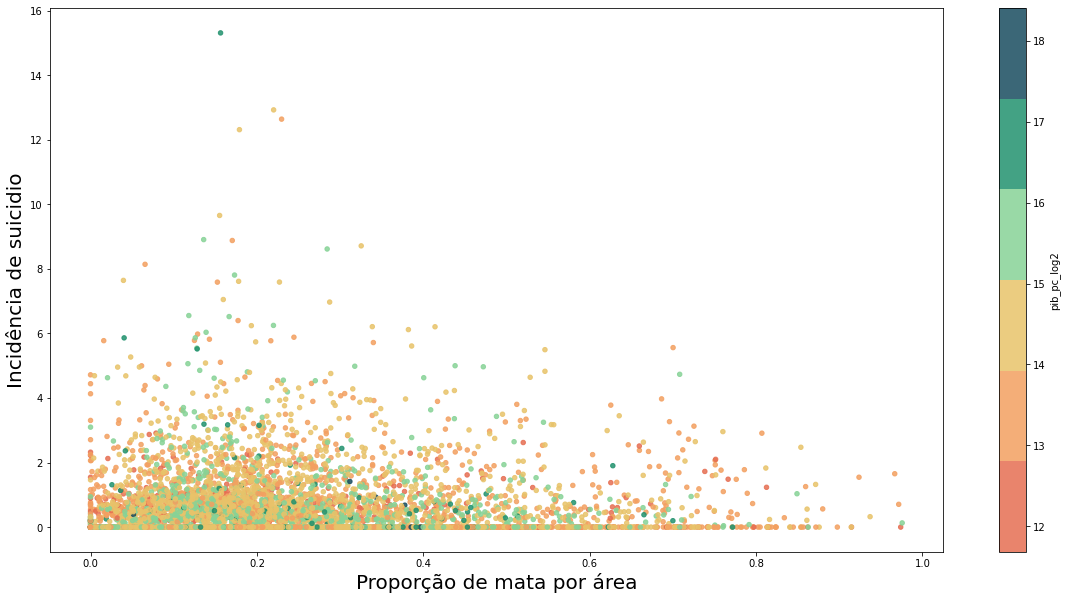

In [84]:
plot(df_2017,'taxa_mata','taxa_sui_10k','pib_pc_log2',
    xlabel='Proporção de mata por área',
    ylabel='Incidência de suicidio')

In [85]:
# Calculating Correlation

df_2017['taxa_sui_10k'].corr(df_2017['taxa_mata'],method='spearman')

0.024473153312414064

In [87]:
# Calculating Mutual Information
# source: [Mutual Information](https://www.kaggle.com/code/ryanholbrook/mutual-information)
from sklearn.feature_selection import mutual_info_regression


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores


df = df_2017.dropna()
make_mi_scores(df.iloc[:, 2:], df.taxa_sui_10k, 'auto')


taxa_sui_10k                  4.501906
populacao                     1.606051
taxa_sui_obitos               1.167933
numero_suicidios              0.716057
area_total                    0.055027
area_mata_natural             0.037171
area_mata                     0.028961
pib_pc                        0.023156
pib_pc_norm                   0.023156
area_mata_plantada            0.020492
pib_pc_log2                   0.020101
area_sistema_agroflorestal    0.011727
taxa_mata                     0.007132
Name: MI Scores, dtype: float64

Downloading: 100%|██████████| 5564/5564 [00:00<00:00, 7443.69rows/s]


<AxesSubplot:xlabel='Proporção de mata por área', ylabel='Incidência de suicidio'>

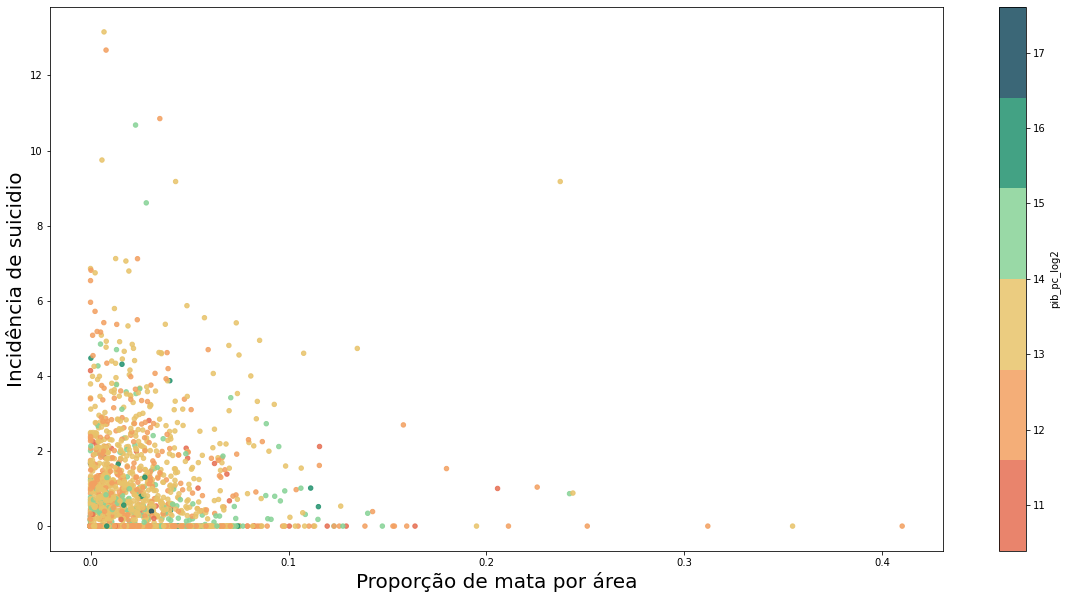

In [88]:
year = 2006
# dfs_2016 = [agro_forest_2006, sim_sui_pop_2006, pib_pc_2006] = get_data.get_dfs(year)
df_2006 = merge_dfs(get_data.get_dfs(year))

plot(df_2006,'taxa_mata','taxa_sui_10k','pib_pc_log2',
    xlabel='Proporção de mata por área',
    ylabel='Incidência de suicidio')

## Conclusions
To explore the possible relation between forest area and suicide rate we gather and combined data on mortality, agricultural census and Brazilian population. Stablished the two variables of interest: the couties' rates of forest (forest area over total area) and suicide (# suicides over population). 

We've used a scatter plot to visualize the data distribution considering suicide rate x forest rate. Complemented by correlation and mutual information scores of the variables. 

As we were expecting, it does't seem the exist a simple, strong, relation between suicides and forest area in Brazilian counties. 
At least in the year of 2017, at least within the limited scope of this brief exploration.

In fact, from the considered variables, population and total area of counties seem the be the most relavant. 

Further research considering economic and social factors from counties, such as median income, gdp per capita, occupation and education could further elucidate this complex matter.

## Extra
Visualizing suicide incidence per Brazilian county

### Acknowledgments: 
- Adapted from: [Base dos Dados - Perfil salarial e de contratações](https://github.com/basedosdados/analises/blob/main/redes_sociais/br_me_caged_20210501.ipynb)

In [31]:
df = df_2017[['id_municipio','taxa_sui_10k']]

In [19]:
import geopandas as gpd
from geobr import read_municipality, read_state
mun = read_municipality(code_muni="all", year=2017)
states = read_state(code_state="all", year=2017)

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import  OffsetImage
from matplotlib import colors, cm

In [89]:
dd = pd.merge(df ,mun, left_on='id_municipio', right_on='code_muni', how='outer')
dd = gpd.GeoDataFrame(dd).sort_values(by='taxa_sui_10k', ascending=False)

<AxesSubplot:>

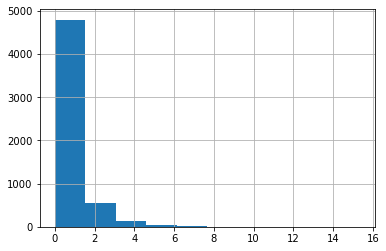

In [90]:
df['taxa_sui_10k'].hist()

(-76.2481752903999,
 -26.578218219599936,
 -35.702328948474204,
 7.2229920307751225)

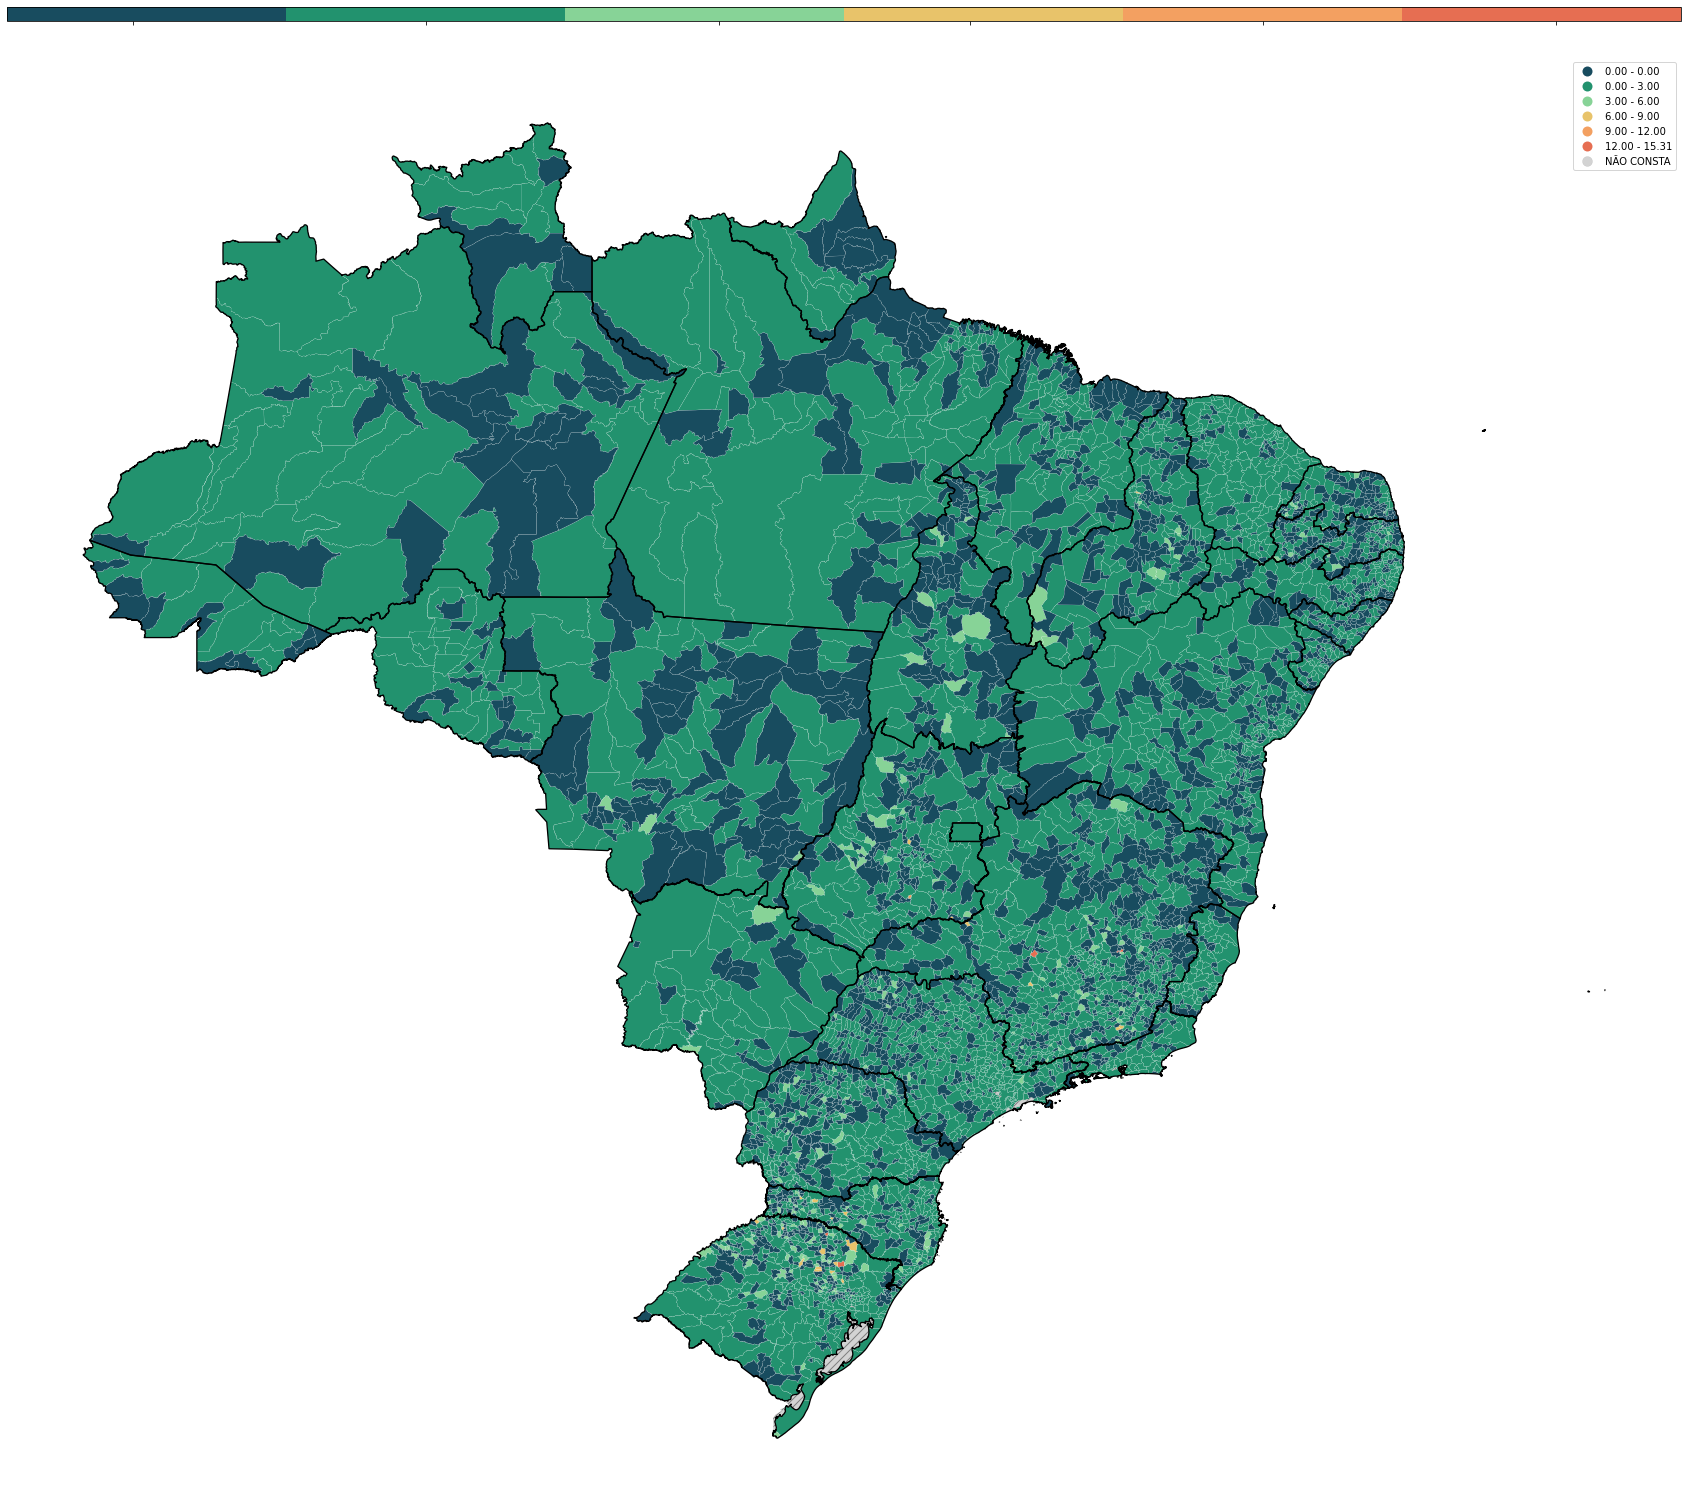

In [91]:
var='taxa_sui_10k'

fig = plt.figure(figsize=(30,30))
ax = plt.subplot(1,1,1)

colors = np.flip([
         "#E66E52",
        "#F3A061",
        "#E8C36A",
        "#87D397",
        "#22926E",
        "#184C5F",
])

cmap = ListedColormap(colors)
colorscale = cmap

divider = make_axes_locatable(ax)
ax_cb = divider.new_vertical(size="1%", pad=0.5, axes_class=plt.Axes)
vmax = dd[var].values.max()
vmin = dd[var].values.min()
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
mappable = plt.cm.ScalarMappable(cmap=colorscale, norm=norm)
fig.add_axes(ax_cb)
labels = [-0.085,-0.050, -0.015,0.015,0.05,0.085]
cbar = fig.colorbar(mappable, cax=ax_cb, ticks=labels,orientation='horizontal')
cbar.ax.set_xticklabels([])
cbar.ax.tick_params(labelsize=28) 

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "grey",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }
# classification = [1000,1200,1300,1400,1800,7200]
classification = (np.linspace(0,12,5))
dd.plot(column=var,
            ax=ax,
            legend=True,
            # legend_kwds = legend_kwds,
            cmap=cmap,
            missing_kwds=missing_kwds,
            scheme='user_defined', 
            classification_kwds={'bins':classification},
            edgecolor='#FFFFFF',
            linewidth = 0.1
       )

states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax)

ax.axis('off')

#Adapted from: [Base dos Dados - Perfil salarial e de contratações](https://github.com/basedosdados/analises/blob/main/redes_sociais/br_me_caged_20210501.ipynb)